# Testing Adaptive Learning with Simulations

### Import Modules

In [1]:
%matplotlib notebook
from __future__ import division # Ensures that a/b is always a float.

import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m
from adaptive import *
from nvdata import *

/Users/ihincks/anaconda/envs/nvadapt/lib/python2.7/site-packages/matplotlib/style/core.py:197: UserWarning: In /Users/ihincks/.matplotlib/stylelib/ggplot-rq.mplstyle: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(message)


In [2]:
from ipyparallel import Client
rc = Client(profile='default2')
dview = rc[:]
dview.use_dill()

with dview.sync_imports():
    import os

# Change directory on engines so that we can import models.
if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
    print "Changed engine directories to notebook directory."

# To ensure that we don't enter into a Matplotlib event loop
# on our engines, we set the MPLBACKEND to the non-interactive
# Agg backend first. This is especially useful if the engines
# are connected via SSH.
if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
    print "Changed MPL backend."

# Force each engine to import QInfer before proceeding.
if dview.execute('import qinfer as qi').get():
    print "Successfully imported QInfer on engines."

if dview.execute('import models').get():
    print "Successfully imported models."

print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


### Setup

Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [3]:
overwrite = True
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

### Stochastic Process Simulators

<IPython.core.display.Javascript object>


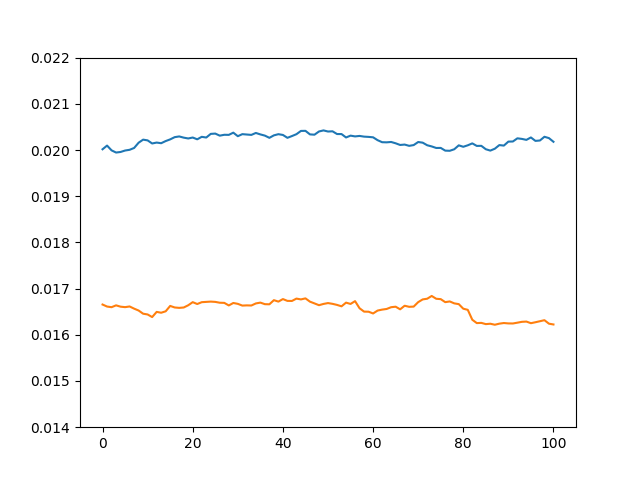

(0.014, 0.022)

In [4]:
drift = NVDriftStepper(mu_alpha=0.02, mu_kappa=0.33,theta_nu=0,theta_kappa=0,background=0.015)
for idx in range(100):
    drift.step(1)
plt.plot(drift.history)
plt.ylim([0.014,0.022])

### Initialize Prior and Sweeps

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")
 - wo: Carrier offset from 2870MHz, positive or negative (MHz)

In [5]:
true_value = np.array([11.6,1.79,1.74778949,2.22,0.61])
target_stds = np.array([0.01,0.01,0.15,0.02,0.05])
wide_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1]
        ]))
narrow_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)
medium_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    10*target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)

In [6]:
ham_model = m.RabiRamseyModel()
ref_model = m.ReferencedPoissonModel(ham_model)

### Experiment Runners

<IPython.core.display.Javascript object>


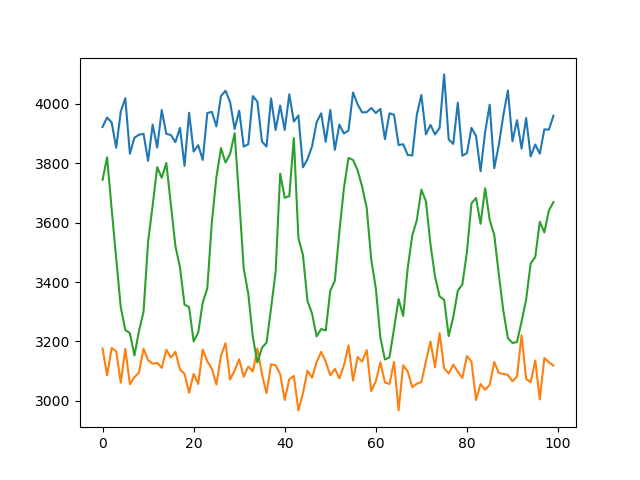

In [8]:
fig = plt.figure()

sim = SimulatedRabiRamseyExperimentRunner(true_value, drift=drift)
rabi_eps = rabi_sweep(max_t=0.3,n=100,n_meas=200000)
results = np.empty((rabi_eps.size, 3))
for idx, eps in enumerate(rabi_eps):
    job = sim.run_experiment(np.atleast_1d(eps))
    while not job.is_complete:
        sleep(0.01)
    results[idx, :] = job.get_result().triplet
plt.plot(results)

### Risk Plots

<IPython.core.display.Javascript object>


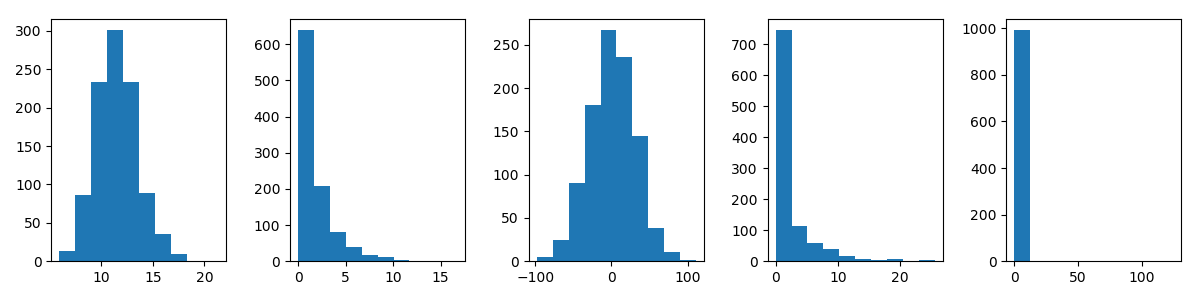

In [36]:
def custom_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
    )

fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(1,5)
for idx in range(5):
    plt.subplot(gs[0,idx])
    plt.hist(custom_prior(200).sample(1000)[:,idx])
    
gs.tight_layout(fig)

In [46]:
mults = np.logspace(np.log10(1),np.log10(200),50)
n_mults = mults.size
rabi_eps = rabi_sweep(max_t=0.5,n=100)
ramsey_eps = ramsey_sweep(max_tau=2,n=100)
rabi_risk_mult = np.empty((n_mults,rabi_eps.size))
ramsey_risk_mult = np.empty((n_mults,ramsey_eps.size))

for idx_mult in range(n_mults):
    mult = mults[idx_mult]
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model, dview), 10, custom_prior(mult))
    risks = updater.bayes_risk(rabi_eps)
    rabi_risk_mult[idx_mult, :] = risks / t
    ramsey_risk_mult[idx_mult, :] = updater.bayes_risk(ramsey_eps)

In [370]:
ham_model.expparams_dtype

[('t', 'float'),
 ('tau', 'float'),
 ('phi', 'float'),
 ('wo', 'float'),
 ('emode', 'int')]

In [386]:
import scipy.optimize as opt

In [ ]:
class RabiRiskOptimizer(object):
    def __init__(self, updater):
        self.updater = updater
        
    def risk_grid(self, min_t, max_t, n_t, min_wo, max_wo, n_wo):
        wos = np.linspace(min_wo, max_wo, n_wo)
        rabi_eps = rabi_sweep(min_t=min_t, max_t=max_t, n=n_t)
        rabi_eps['t'] = 0.002 * np.round(rabi_eps['t'] / 0.002)
        risks = np.empty((n_wo, n_t))
        for idx_wo, wo in enumerate(wos):
            rabi_eps['wo'] = wo
            risks[idx_wo, :] = self.updater.bayes_risk(rabi_eps)
        return risks
    
    

In [411]:
def optimize_rabi_risk(updater):
    uncached_model =  m.RabiRamseyModel()
    uncached_model.simulator = {
        m.RabiRamseyModel.RABI: m.rabi,
        m.RabiRamseyModel.RAMSEY: m.ramsey
    }
    
    #omega, we, zfs, an, T2i = updater.est_mean()[:5]
    rabi_eps = rabi_sweep(max_t=1,n=100,wo=0)
    risk_slice = updater.bayes_risk(rabi_eps)
    
    min_eps = rabi_eps[int(np.argmin(risk_slice))]
    x0 = [min_eps['t'], min_eps['wo']]
    print x0
    
    old_model = updater.model
    updater.model = qi.DirectViewParallelizedModel(uncached_model, dview)
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    emode = m.RabiRamseyModel.RABI
    def relative_risk(x):
        t, wo = x
        eps = np.array(
            [(t, 0, 0, wo, emode)], 
            dtype=[('t', 'float'), ('tau', 'float'), ('phi', 'float'), ('wo', 'float'), ('emode', 'int')]
        )
        return updater.bayes_risk(eps) / risk0
    result = opt.fmin_bfgs(relative_risk, x0)
    updater.model = old_model
    
    return result

In [412]:
optimize_rabi_risk(updater)

[0.02, 0.0]
Optimization terminated successfully.
         Current function value: 0.692847
         Iterations: 8
         Function evaluations: 96
         Gradient evaluations: 24


array([  2.06294301e-02,  -2.29431125e+01])

In [392]:
optimize_rabi_risk(updater)

Optimization terminated successfully.
         Current function value: 0.991960
         Iterations: 2
         Function evaluations: 68
         Gradient evaluations: 17


array([ 0.04      ,  1.40215959])

In [413]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model, dview), 1000, custom_prior(mults[idx_mult]))

In [433]:
%timeit updater.bayes_risk(rabi_sweep(max_t=1,n=1,wo=np.random.rand()))

10 loops, best of 3: 95.2 ms per loop


In [431]:
%timeit updater.bayes_risk(rabi_sweep(max_t=1,n=10,wo=np.random.rand()))

10 loops, best of 3: 107 ms per loop


In [435]:
%timeit updater.bayes_risk(rabi_sweep(max_t=1,n=200,wo=np.random.rand()))

1 loop, best of 3: 479 ms per loop


In [428]:
a

In [358]:
rabi_risk_wo_00010 = rabi_risk_wo.copy()
ramsey_risk_wo_00010 = ramsey_risk_wo.copy()

In [368]:
mults = np.array([1,10,100])
wos = np.linspace(-10,10,51)
n_wos = wos.size
n_mults = mults.size
rabi_risk_wo = np.empty((n_mults,n_wos,rabi_eps.size))
ramsey_risk_wo = np.empty((n_mults,n_wos,ramsey_eps.size))


for idx_mult in range(n_mults):
    ham_model._Q = np.array([0,1,0,0,0])
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model, dview), 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    for idx_wo in range(n_wos):
        rabi_eps = rabi_sweep(max_t=1,n=100,wo=wos[idx_wo])
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=0.022,wo=wos[idx_wo])
        rabi_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(rabi_eps) / risk0
        ramsey_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


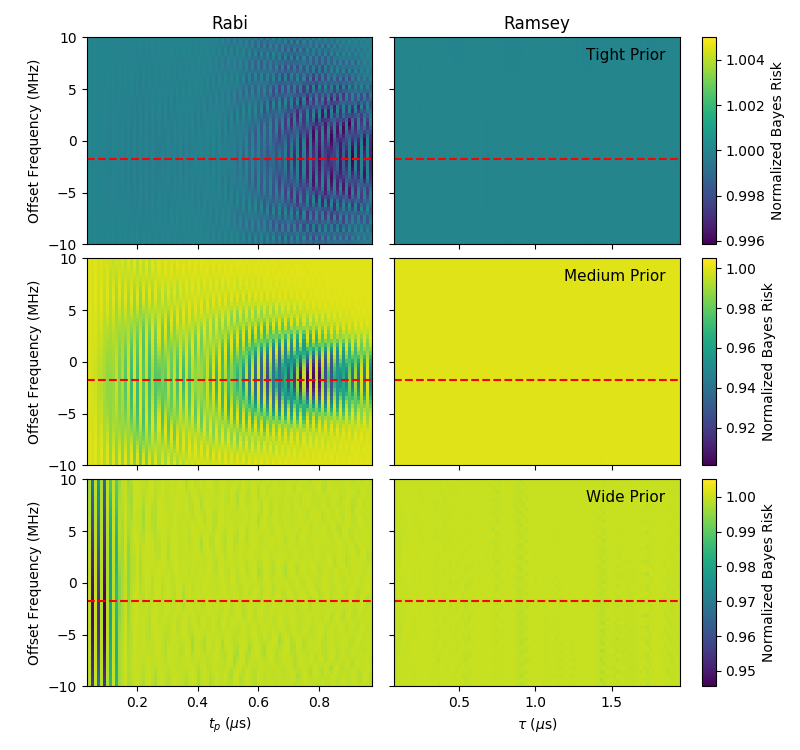

In [367]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017 * 2
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(n_mults):
    
    vmin = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    ax_rabi.invert_yaxis()
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(-true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(-true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar)#, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

<IPython.core.display.Javascript object>


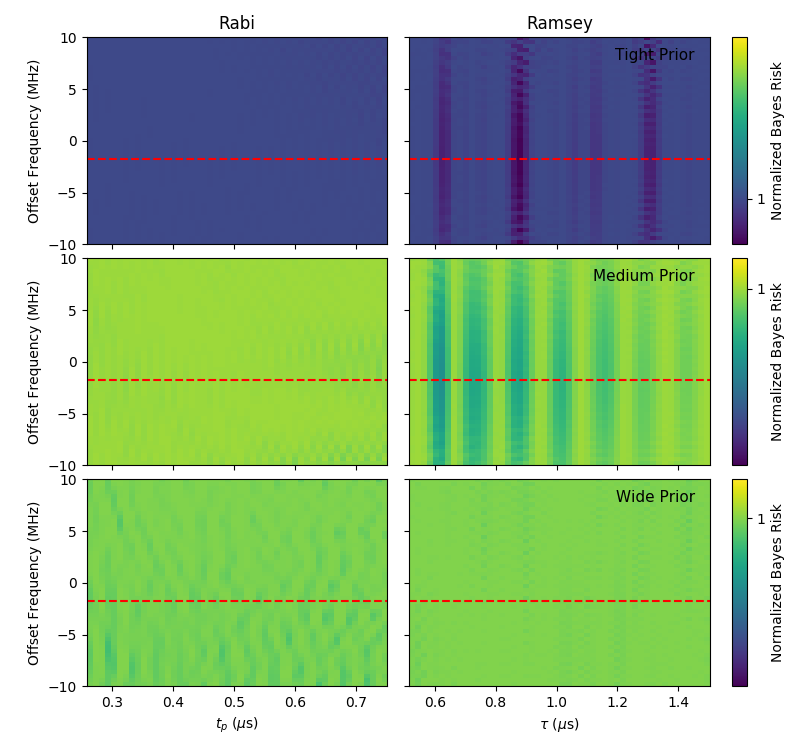

In [369]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(n_mults):
    
    vmin = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    ax_rabi.invert_yaxis()
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(-true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(-true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

<IPython.core.display.Javascript object>


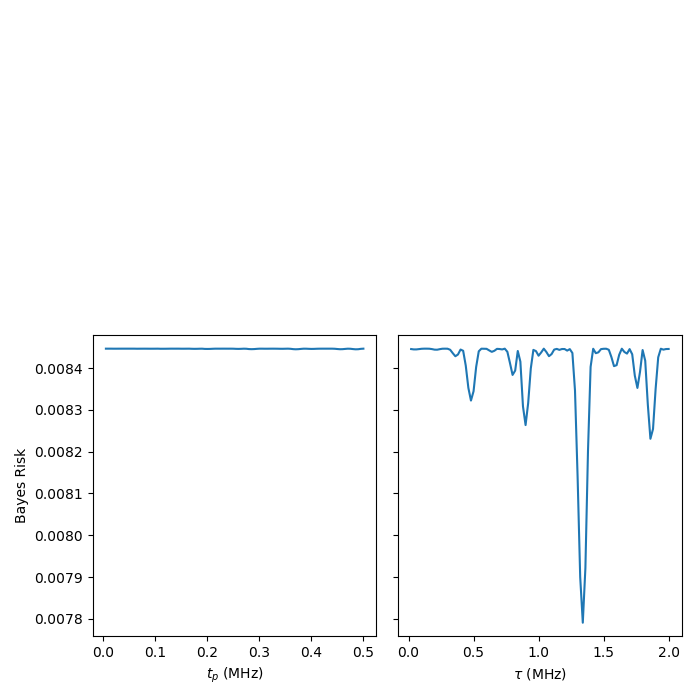

In [10]:
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(2,2)

ax_rabi_risk = plt.subplot(gs[1,0])
plt.plot(rabi_eps['t'], rabi_risk)
plt.xlabel('$t_p$ (MHz)')
plt.ylabel('Bayes Risk')

ax_ramsey_risk = plt.subplot(gs[1,1], sharey=ax_rabi_risk)
plt.plot(ramsey_eps['tau'], ramsey_risk)
plt.xlabel(r'$\tau$ (MHz)')

plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
gs.tight_layout(fig)

### Adaptive Simulations

In [87]:
n_meas = 100000
n_particles = 2000
n_experiments = 100
n_trials = 1

sim = SimulatedRabiRamseyExperimentRunner(true_value)

def make_updater():
    return qi.DirectViewParallelizedModel(
        qi.GaussianRandomWalkModel(
            m.ReferencedPoissonModel(m.RabiRamseyModel()),
            random_walk_idxs=[5,6],
            diagonal=False,
            scale_mult=experiment_time
        ), 
        dview, 
        serial_threshold=1
    )

Q = np.array([1,1,0,0,0])

heuristics = []

track_means = np.zeros((n_trials, n_experiments + 1, 10))
track_covs = np.zeros((n_trials, n_experiments + 1, 10, 10))

for idx_trial in range(n_trials):
    heuristic = RiskHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, qi.ProductDistribution(wide_prior,drift_prior)), 
        Q, 
        rabi_sweep(max_t=0.5, n=50, n_meas=n_meas), 
        ramsey_sweep(max_tau=2, n=50, n_meas=n_meas)
    )
    heuristics.append(heuristic)
    updater = heuristic.updater

    track_means[idx_trial, 0, :] = heuristic.updater.est_mean()
    track_covs[idx_trial, 0, :, :] = heuristic.updater.est_covariance_mtx()

    for idx_eps in range(n_experiments):

        #estimate ramsey pulse time
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002

        #decide experiment
        eps = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))

        # simulate outcome
        outcome = sim.run_experiment(eps)

        # update
        eps['mode'] = ref_model.BRIGHT
        bright = updater.update(outcome.bright, eps)
        eps['mode'] = ref_model.DARK
        dark = updater.update(outcome.dark, eps)
        eps['mode'] = ref_model.SIGNAL
        signal = updater.update(outcome.signal, eps)

        # store info
        track_means[idx_trial, idx_eps + 1, :] = updater.est_mean()
        track_covs[idx_trial, idx_eps + 1, :, :] = updater.est_covariance_mtx()

ValueError: operands could not be broadcast together with shapes (5,) (2,100,2000,10) 

Overwriting ../fig/qhl-wr-variance.png
Overwriting ../fig/qhl-wr-variance.pdf


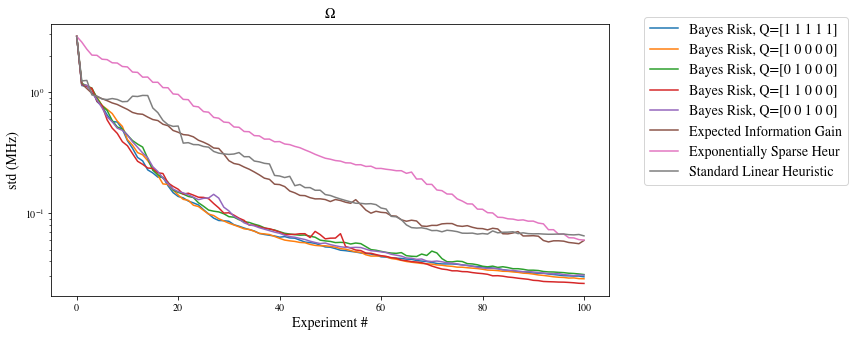

In [102]:
idx_model = 0
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-wr-variance')

Overwriting ../fig/qhl-we-variance.png
Overwriting ../fig/qhl-we-variance.pdf


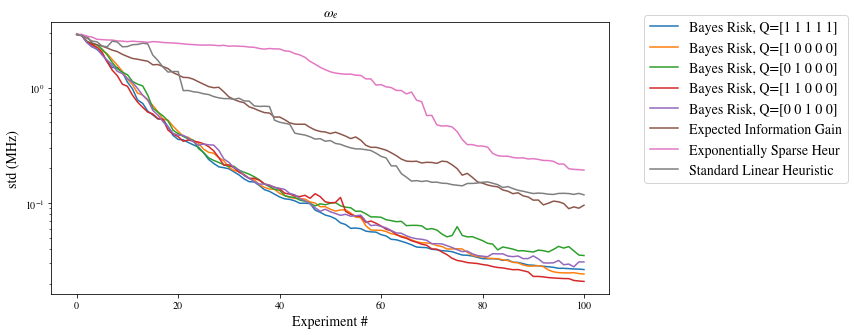

In [103]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-we-variance')

Overwriting ../fig/qhl-AN-variance.png
Overwriting ../fig/qhl-AN-variance.pdf


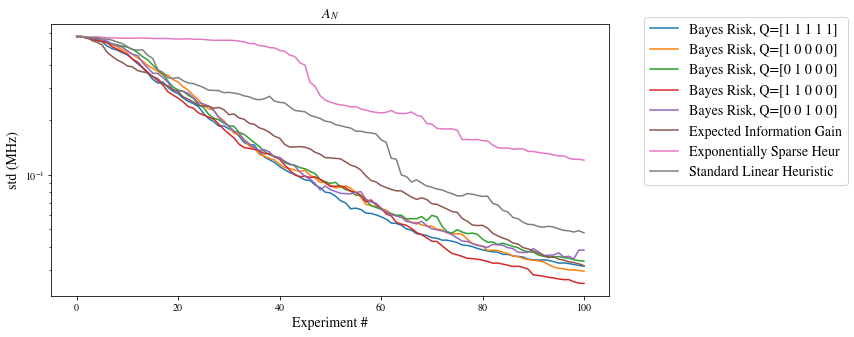

In [104]:
idx_model = 3
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-AN-variance')

### Lookahead Heuristic

It would be beneficial to do risk calculations at the same time as experiments, since both tasks are time consuming. The problem, however, is that calculating the best next experiment to do next relies on the latest data, which we would not have if we are doing experiments and calculations concurrently. Three ideas:
 - Scrap concurrency, and just alternate between experiments and next best experiment simulations
 - Choose the next experiment based on the previous posterior, so that one is always slightly out of touch
 - Marginalize the heuristic over the hypothetical outcomes of the currently running experiment

In [80]:
def lookahead_bayes_risk(updater, first_expparams, second_expparams):
    
    # assume n_out1==n_out2==n_out for convenience
    n_out = updater.model.n_outcomes(np.atleast_1d(first_expparams)[0])
    n_eps1 = first_expparams.size
    n_eps2 = second_expparams.size
    
    # compute all likelihoods
    # the likelihood over outcomes should sum to 1, so don't compute for last outcome for efficiency
    L = updater.model.likelihood(
            np.arange(n_out-1), 
            updater.particle_locations,
            np.concatenate([first_expparams, second_expparams])
        )
    L = np.concatenate([L, (1 - L.sum(axis=0))[np.newaxis, ...]], axis=0).transpose((0,2,1))
    L1 = L[:, :first_expparams.size, :]              # L1.shape == (n_out1, n_eps1, n_particles)
    L2 = L[:, first_expparams.size:, :]              # L1.shape == (n_out2, n_eps2, n_particles)
    
    # compute the hypothetical posterior weights after the first hypothetical experiments, w_hyp1
    # and compute the hypothetical outcome probabilities, N1
    w_hyp1 = L1 * updater.particle_weights[np.newaxis, np.newaxis, :]
    
    # compute the hypothetical posterior weights after all 
    # combinations of first and second expparams and outcomes
    w_hyp12 = w_hyp1[:, np.newaxis, :,  np.newaxis, :] * L2[np.newaxis, :, np.newaxis, :, :]
    N12 = np.sum(w_hyp12, axis=4)                    # N12.shape = (n_out1, n_out2, n_eps1, n_eps2)
    w_hyp12 = w_hyp12 / N12[:, :, :, :, np.newaxis]  # w_hyp12.shape = (n_out1, n_out2, n_eps1, n_eps2, n_particles)

    # compute the hypothetical means and variances given outcomes and exparams
    # mu_hyp12.shape == (n_out1, n_out2, n_eps1, n_eps2, n_models)
    # var_hyp12.shape == (n_out1, n_out2, n_eps1, n_eps2)
    mu_hyp12 = np.dot(w_hyp12, updater.particle_locations)
    var_hyp12 = np.sum(
        w_hyp12 * 
        np.sum(updater.model.Q * (
            updater.particle_locations[np.newaxis, np.newaxis,np.newaxis,np.newaxis,:,:] - 
            mu_hyp12[:,:,:,:,np.newaxis,:]
        ) ** 2,  axis=5),
        axis=4
    )
    
    # the risk of a given expparam can be calculated as the mean posterior
    # variance weighted over all possible outcomes
    return np.sum(np.sum(N12 * var_hyp12, axis=0), axis=0)

class LookAheadRiskHeuristic(qi.Heuristic):
    def __init__(self, updater, Q, rabi_eps, ramsey_eps, name=None):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._ham_model._Q = Q
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Look-Ahead Bayes Risk, Q={}".format(Q) if name is None else name
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, current_eps, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        risk = lookahead_bayes_risk(self._risk_taker, current_eps, all_eps)[0,:]
        self.risk_history += [risk]
        best_idx = np.argmin(risk, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps

In [76]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, medium_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 lookahead_bayes_risk(updater, rabi_eps[4,np.newaxis], rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)

1 loop, best of 1: 904 ms per loop
1 loop, best of 1: 847 ms per loop


Overwriting ../fig/risk-look-ahead.png
Overwriting ../fig/risk-look-ahead.pdf


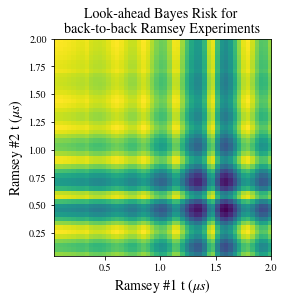

In [75]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, medium_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
lbr = lookahead_bayes_risk(updater, rabi_eps, rabi_eps)
fig = plt.figure()
plt.imshow(lbr, extent=[np.min(ramsey_eps['tau']),np.max(ramsey_eps['tau']),np.min(ramsey_eps['tau']),np.max(ramsey_eps['tau'])])
plt.title('Look-ahead Bayes Risk for \nback-to-back Ramsey Experiments')
plt.xlabel('Ramsey #1 t $(\mu s)$')
plt.ylabel('Ramsey #2 t $(\mu s)$')
export_figure(fig, 'risk-look-ahead')

In [ ]:
n_bin = 10
n_particles = 2000
n_experiments = 100
n_trials = 50

def make_updater():
    if not parallel:
        return qi.BinomialModel(m.RabiRamseyModel())
    else:
        return qi.DirectViewParallelizedModel(qi.BinomialModel(m.RabiRamseyModel()), dview, serial_threshold=1)

Q = np.array([1,1,0,0,0])
n_updaters=3

heuristics_hal = []

track_means_lah = np.zeros((n_trials, n_updaters, n_experiments + 1, 5))
track_covs_lah = np.zeros((n_trials, n_updaters, n_experiments + 1, 5, 5))

for idx_trial in range(n_trials):
    print "Starting Trial {}".format(idx_trial)
    print "================="
    
    heuristics_hal.append([])
    heuristics_hal[-1] = [
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Alternating    '
        ),
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Old Information'
        ),
        LookAheadRiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin),
            name='Bayes Risk: Look-Ahead     '
        ),
    ]
    
    for idx_h, h in enumerate(heuristics_hal[-1]):
        track_means_lah[idx_trial,idx_h, 0, :] = h.updater.est_mean()
        track_covs_lah[idx_trial,idx_h, 0, :, :] = h.updater.est_covariance_mtx()
        
    # heuristics 1 and 2 require an initial experiment to run
    eps0 = None
    current_est = heuristics_hal[-1][1].updater.est_mean()
    tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
    eps1 = heuristics_hal[-1][1](tp_est)
    eps2 = eps1

    for idx_eps in range(n_experiments):

        #--------------------------------------------------------------------
        # Alternating Heuristic: alternate experiments with risk optimization
        
        idx = 0
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        #estimate ramsey pulse time
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        #decide experiment
        eps0 = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps0[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # simulate outcome
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps0)
        # update
        updater.update(outcome, eps0)
        
        #--------------------------------------------------------------------
        # Old Info Heuristic:    compute risk concurrently, but on the old 
        #                        posterior
        
        idx = 1
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        # simulate outcome _before_ knowing best thing to do
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps1)
        # "simultaneously" decide next experiment based on old distribution
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        eps1_new = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps1_new[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # now both the experiment and the simulation are done, do the update
        updater.update(outcome, eps1)
        eps1 = eps1_new
        
        #--------------------------------------------------------------------
        # Look-Ahead Heuristic:  Take into account what we expect from the 
        #                        currently running experiment
        
        idx = 2
        heuristic = heuristics_hal[-1][idx]
        updater = heuristic.updater
        # simulate outcome _before_ knowing best thing to do
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps2)
        # "simultaneously" decide next experiment based on old distribution and currently running experiment
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002
        eps2_new = heuristic(eps2, tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps2_new[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))
        # now both the experiment and the simulation are done, do the update
        updater.update(outcome, eps2)
        eps2 = eps2_new
        
        # store info
        for idx_h, h in enumerate(heuristics_hal[-1]):
            track_means_lah[idx_trial,idx_h, idx_eps, :] = h.updater.est_mean()
            track_covs_lah[idx_trial,idx_h, idx_eps, :, :] = h.updater.est_covariance_mtx()
        
        print "---"

Starting Trial 0
0: Bayes Risk: Alternating     : ( 0.03,  0.,  0.,  0., 0, 10) [ 2896.  2887.  2852.   575.   293.]
0: Bayes Risk: Old Information : ( 0.03,  0.,  0.,  0., 0, 10) [ 2869.  2913.  2901.   577.   276.]
0: Bayes Risk: Look-Ahead      : ( 0.03,  0.,  0.,  0., 0, 10) [ 2857.  2893.  2938.   582.   284.]
---
1: Bayes Risk: Alternating     : ( 0.05,  0.,  0.,  0., 0, 10) [ 1409.  2850.  3107.   577.   279.]
1: Bayes Risk: Old Information : ( 0.05,  0.,  0.,  0., 0, 10) [ 1278.  2846.  2980.   566.   276.]
1: Bayes Risk: Look-Ahead      : ( 0.12,  0.,  0.,  0., 0, 10) [  957.  2848.  2953.   575.   272.]
---
2: Bayes Risk: Alternating     : ( 0.15,  0.,  0.,  0., 0, 10) [ 1034.  2677.  2580.   575.   289.]
2: Bayes Risk: Old Information : ( 0.1,  0.,  0.,  0., 0, 10) [ 1007.  2930.  3036.   578.   263.]
2: Bayes Risk: Look-Ahead      : ( 0.15,  0.,  0.,  0., 0, 10) [ 1017.  2779.  3151.   570.   261.]
---
3: Bayes Risk: Alternating     : ( 0.17,  0.,  0.,  0., 0, 10) [  942.  

Overwriting ../fig/qhl-lah-we-variance.png
Overwriting ../fig/qhl-lah-we-variance.pdf


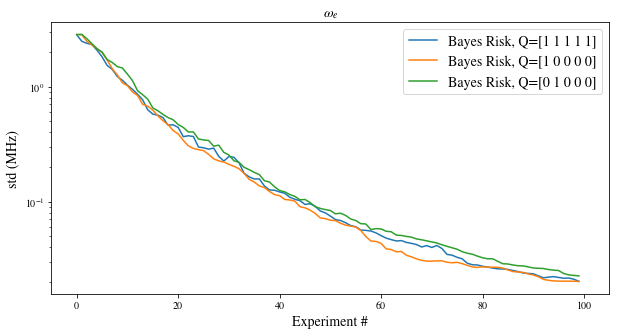

In [101]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(len(heuristics_hal)):
    h = heuristics_hal[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs_lah[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-lah-we-variance')